In [1]:
import pandas as pd

In [2]:
cost_df=pd.read_excel('C:\\Users\\smrc\\OneDrive\\Desktop\\datasets\\cost.xlsx')

In [3]:
credit_df=pd.read_excel('C:\\Users\\smrc\\OneDrive\\Desktop\\datasets\\credit_2018_2019.xlsx')

In [4]:
revenue_target_df=pd.read_excel('C:\\Users\\smrc\\OneDrive\\Desktop\\datasets\\revenue_target.xlsx')

In [5]:
revenue_target_df.head()

,CLIENTNUM,quarter,Year,Date,Type,Card_Category,Target Revenue
0,708082083,Q1,2018,"Q1,2018",Shop,Blue,4.204200
1,708083283,Q1,2018,"Q1,2018",Shop,Blue,4.744425
2,708084558,Q1,2018,"Q1,2018",Shop,Blue,13.869450
3,708085458,Q1,2018,"Q1,2018",Shop,Blue,4.303425
4,708086958,Q1,2018,"Q1,2018",Shop,Blue,4.712400


In [6]:
cost_df.head()

,Year (cost),Quarter (cost),Type (cost),CostPerType_Q
0,2018,Q1,salary,11000
1,2018,Q1,marketing,8800
2,2018,Q1,service,13000
3,2018,Q1,IT,7200
4,2018,Q2,salary,11000


In [7]:
credit_df.head()

,CLIENTNUM,Attrition_Flag,Year,Quarter,Date,Type,Trans_Amount,Revenue
0,708082083,Existing Customer,2018,Q1,"Q1,2018",Shop,120.120,2.4024
1,708083283,Attrited Customer,2018,Q1,"Q1,2018",Shop,135.555,2.7111
2,708084558,Attrited Customer,2018,Q1,"Q1,2018",Shop,396.270,7.9254
3,708085458,Existing Customer,2018,Q1,"Q1,2018",Shop,122.955,2.4591
4,708086958,Existing Customer,2018,Q1,"Q1,2018",Shop,134.640,2.6928


## Objective

To estimate the Revenue to be collected in the next year using data that was collected in the previous years. This will help the organization to plan and effectivrly allocate resources where needed.

In [8]:
df_main = pd.merge(revenue_target_df, credit_df[['CLIENTNUM','Attrition_Flag','Trans_Amount','Revenue']], on='CLIENTNUM')

In [9]:
df_main.head()

,CLIENTNUM,quarter,Year,Date,Type,Card_Category,Target Revenue,Attrition_Flag,Trans_Amount,Revenue
0,708082083,Q1,2018,"Q1,2018",Shop,Blue,4.2042,Existing Customer,120.1200,2.402400
1,708082083,Q1,2018,"Q1,2018",Shop,Blue,4.2042,Existing Customer,40.0400,0.800800
2,708082083,Q1,2018,"Q1,2018",Shop,Blue,4.2042,Existing Customer,60.0600,1.201200
3,708082083,Q1,2018,"Q1,2018",Shop,Blue,4.2042,Existing Customer,180.1800,3.603600
4,708082083,Q1,2018,"Q1,2018",Shop,Blue,4.2042,Existing Customer,215.4624,4.309248


## Load Libraries

In [10]:
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import numpy as np


import time
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
## Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

## Display all rows and columns of a dataframe instead of a truncated version
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [12]:
# since the df has around 10M records, we will take a sample of 10K random records
df_main = df_main.sample(n=5000, random_state=42)

In [13]:
df_main.shape

(5000, 10)

In [14]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 211630 to 1635985
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CLIENTNUM       5000 non-null   int64  
 1   quarter         5000 non-null   object 
 2   Year            5000 non-null   int64  
 3   Date            5000 non-null   object 
 4   Type            5000 non-null   object 
 5   Card_Category   5000 non-null   object 
 6   Target Revenue  5000 non-null   float64
 7   Attrition_Flag  5000 non-null   object 
 8   Trans_Amount    5000 non-null   float64
 9   Revenue         5000 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 429.7+ KB


## Data Cleaning

In [15]:
## missing values in percentage
percentage_missing=df_main.isnull().sum()*100/len(df_main)

In [16]:
percentage_missing

CLIENTNUM         0.0
quarter           0.0
Year              0.0
Date              0.0
Type              0.0
Card_Category     0.0
Target Revenue    0.0
Attrition_Flag    0.0
Trans_Amount      0.0
Revenue           0.0
dtype: float64

In [17]:
duplicates_check=df_main.duplicated()

In [18]:
df_main.drop(['quarter', 'Year','CLIENTNUM'], axis=1, inplace=True)

In [19]:
# Assumng df_main is your DataFrame
df_main = df_main.reset_index(drop=True)

## EDA

In [20]:
df_main.describe().T

,count,mean,std,min,25%,50%,75%,max
Target Revenue,5000.0,12.020899,15.950111,0.0,2.860719,6.655625,14.288963,140.207517
Trans_Amount,5000.0,232.944600,325.231752,0.0,51.518150,123.692100,273.662550,3694.185000
Revenue,5000.0,6.595432,8.351669,0.0,1.705174,3.617776,8.469532,75.892080


In [21]:
df_main.describe(include='object')

,Date,Type,Card_Category,Attrition_Flag
count,5000,5000,5000,5000
unique,8,4,4,2
top,"Q1,2019",Shop,Blue,Existing Customer
freq,680,1272,4667,4734


## Target Variable visualization

In [22]:
df_main.columns

Index(['Date', 'Type', 'Card_Category', 'Target Revenue', 'Attrition_Flag',
       'Trans_Amount', 'Revenue'],
      dtype='object')

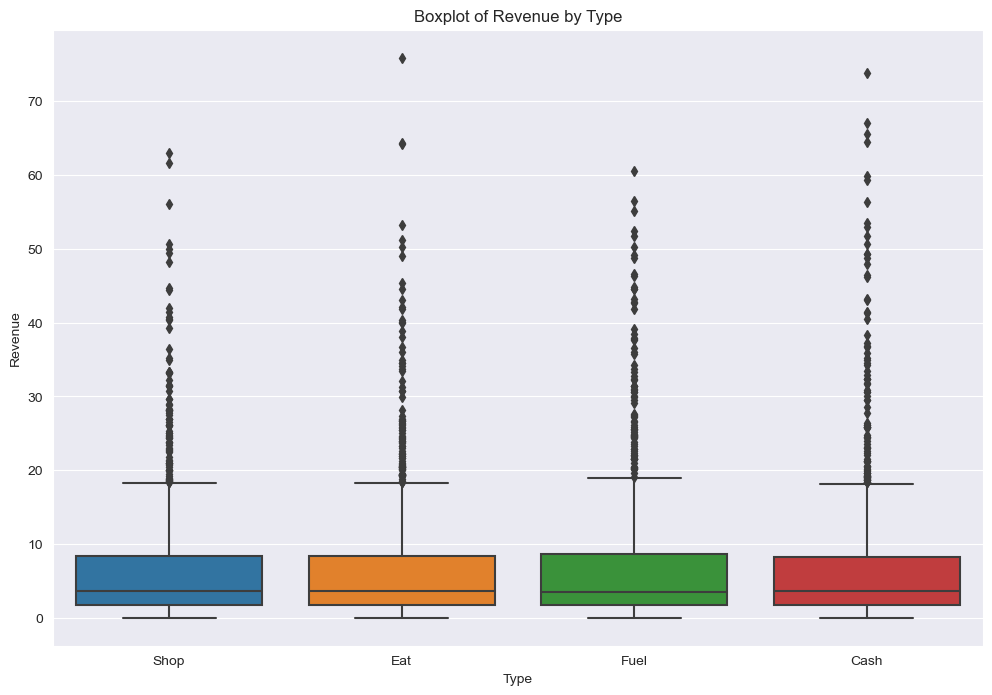

In [23]:
#Create boxplots to show the distribution of "Revenue" for different categories in categorical variables.
plt.figure(figsize=(12, 8))
sns.boxplot(x='Type', y='Revenue', data=df_main)
plt.title('Boxplot of Revenue by Type')

plt.savefig(r'C:\\Users\\smrc\\OneDrive\\Desktop\\Credit Card Revenue Prediction\\images and plots\\Boxplot of Revenue by Type.png')


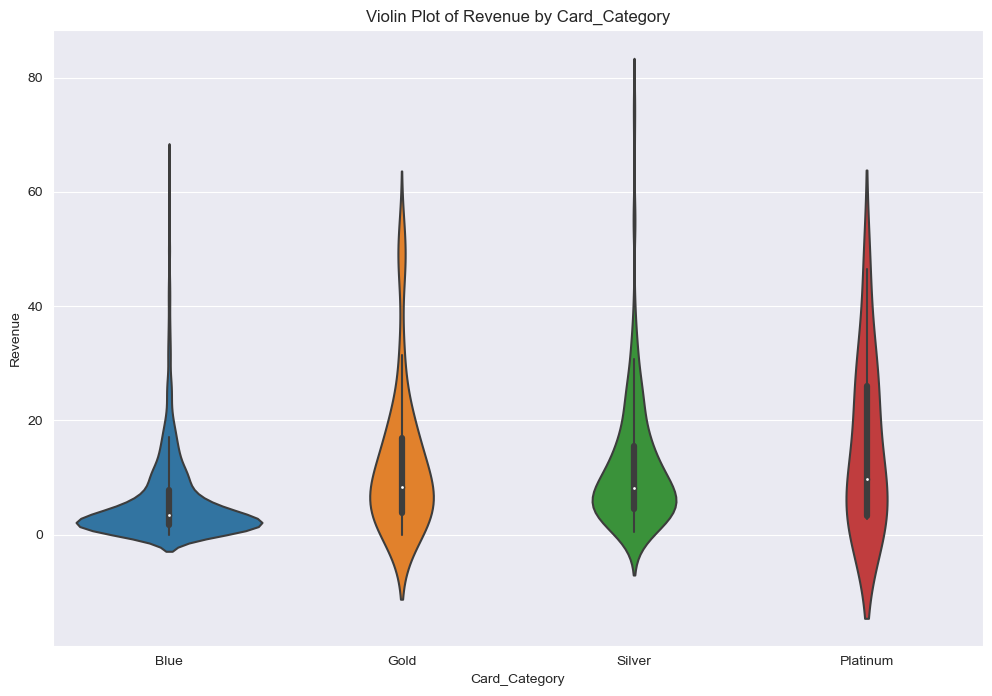

In [24]:
#Violin plots can provide a combination of boxplots and kernel density estimation. They are useful for visualizing the distribution of "Revenue" within different categories.
plt.figure(figsize=(12, 8))
sns.violinplot(x='Card_Category', y='Revenue', data=df_main)
plt.title('Violin Plot of Revenue by Card_Category')

plt.savefig(r'C:\\Users\\smrc\\OneDrive\\Desktop\\Credit Card Revenue Prediction\\images and plots\\Violin Plot of Revenue by Card_Category.png')


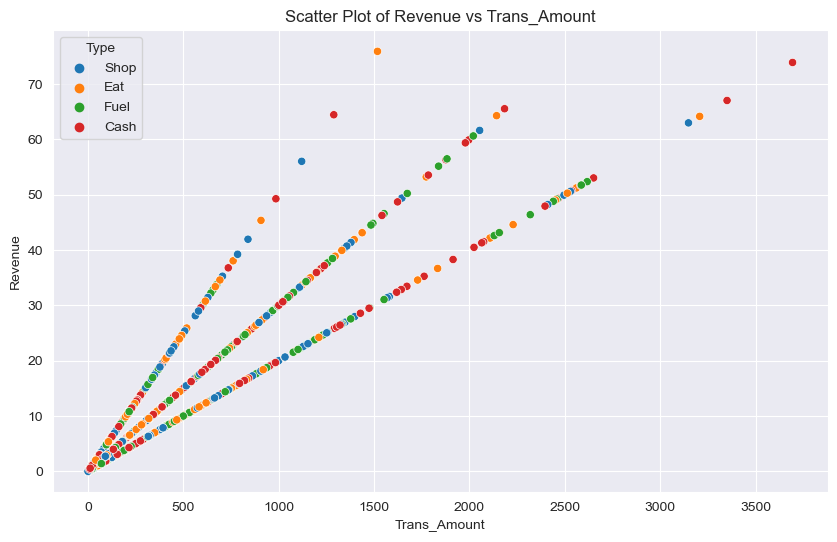

In [25]:
#Use scatter plots to visualize the relationship between "Trans_Amount" and "Revenue," coloring the points based on another categorical variable like "Type."
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Trans_Amount', y='Revenue', hue='Type', data=df_main)
plt.title('Scatter Plot of Revenue vs Trans_Amount')

plt.savefig(r'C:\\Users\\smrc\\OneDrive\\Desktop\\Credit Card Revenue Prediction\\images and plots\\Scatter Plot of Revenue vs Trans_Amount.png')

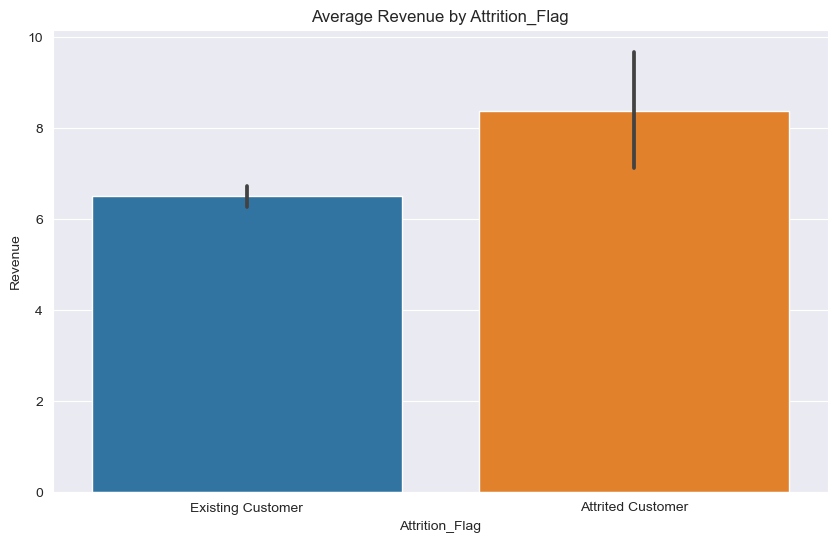

In [26]:
#Create bar plots to compare the average "Revenue" for different categories.
plt.figure(figsize=(10, 6))
sns.barplot(x='Attrition_Flag', y='Revenue', data=df_main)
plt.title('Average Revenue by Attrition_Flag')

plt.savefig(r'C:\\Users\\smrc\\OneDrive\\Desktop\\Credit Card Revenue Prediction\\images and plots\\Average Revenue by Attrition_Flag.png')

Text(0.5, 1.0, 'Correlation Matrix Heatmap with Revenue')

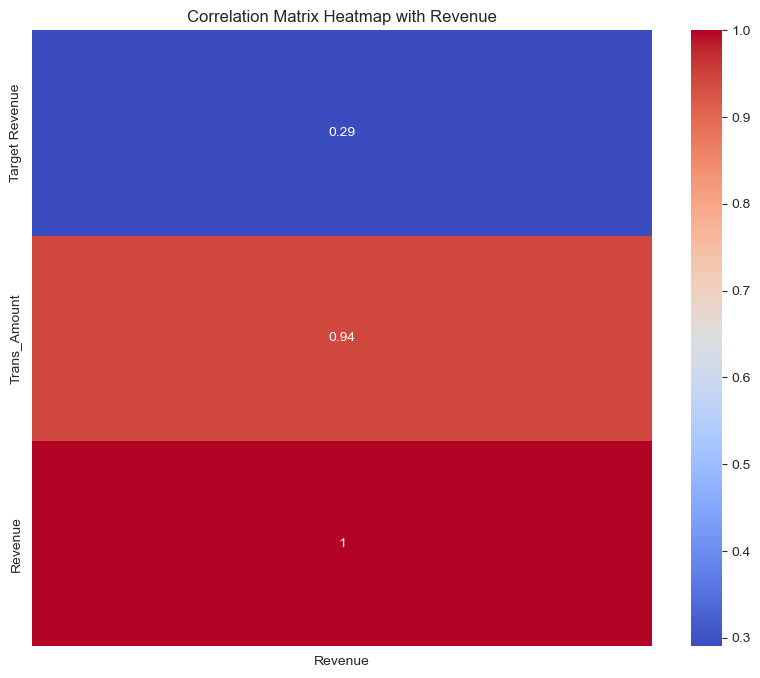

In [27]:
#Create a heatmap to visualize the correlation between all numerical variables, including "Revenue."
correlation_matrix = df_main.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['Revenue']], annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap with Revenue')

## Distribution

In [28]:
num=df_main.select_dtypes(exclude=['object'])
num

,Target Revenue,Trans_Amount,Revenue
0,11.320200,34.4240,1.721200
1,6.460272,643.1040,19.293120
2,8.190468,356.3840,10.691520
3,2.757888,32.8320,0.984960
4,5.175828,754.7100,15.094200
5,3.981570,124.0050,2.480100
6,3.200400,411.4800,12.344400
7,6.579000,205.2000,10.260000
8,4.596480,51.7200,1.551600
9,0.410880,708.1500,21.244500


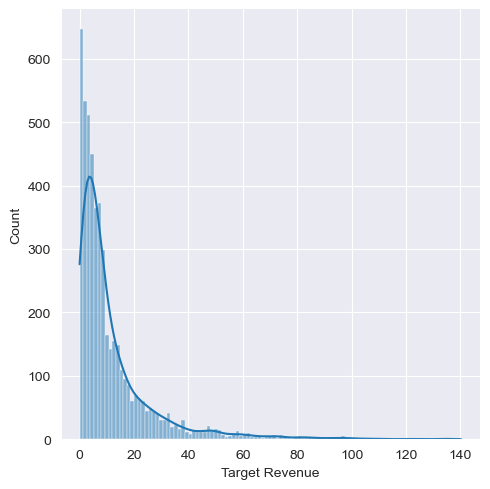

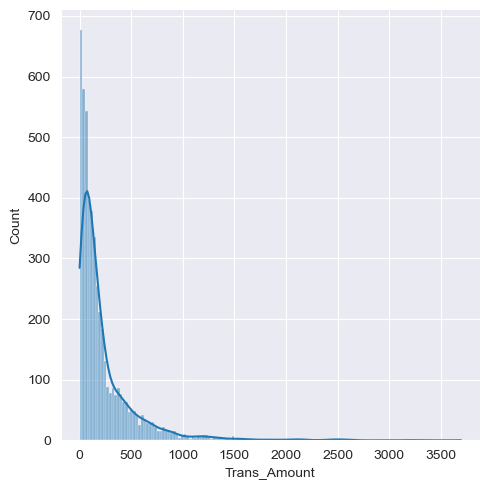

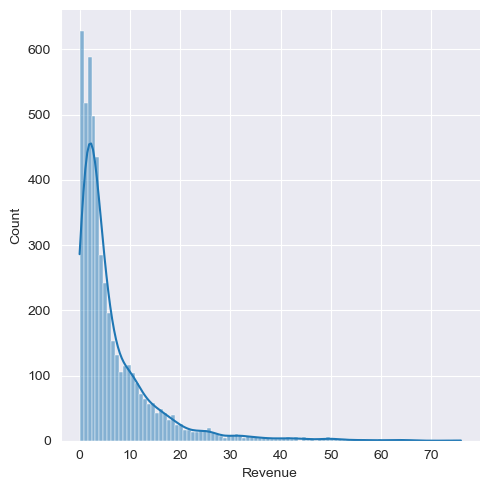

In [29]:
## Distribution plots for numerical data
for i in range(len(num.columns)):   
    sns.displot(num.iloc[:,i],kde=True)
    plt.xlabel(num.columns[i])

plt.tight_layout()
plt.show()

In [30]:
df_main.columns

Index(['Date', 'Type', 'Card_Category', 'Target Revenue', 'Attrition_Flag',
       'Trans_Amount', 'Revenue'],
      dtype='object')

### Outliers

<Axes: >

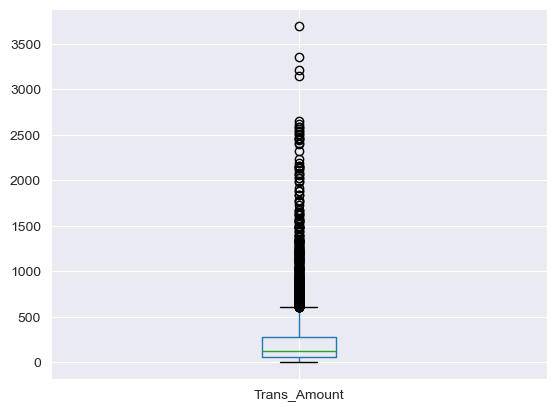

In [31]:
df_main.boxplot(column='Trans_Amount')

<Axes: >

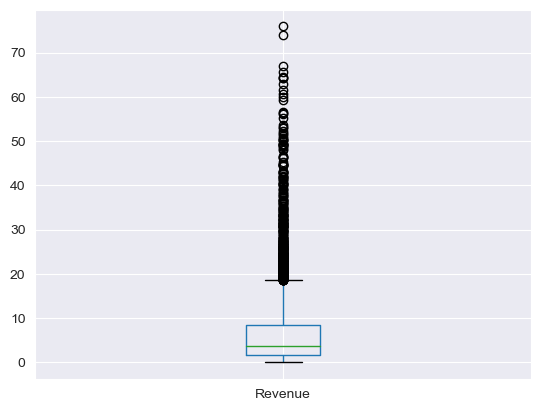

In [32]:
df_main.boxplot(column='Revenue')

In [33]:
df_main.head()

,Date,Type,Card_Category,Target Revenue,Attrition_Flag,Trans_Amount,Revenue
0,"Q4,2019",Shop,Blue,11.320200,Existing Customer,34.424,1.72120
1,"Q3,2019",Eat,Gold,6.460272,Existing Customer,643.104,19.29312
2,"Q3,2019",Fuel,Blue,8.190468,Existing Customer,356.384,10.69152
3,"Q1,2019",Shop,Blue,2.757888,Existing Customer,32.832,0.98496
4,"Q4,2019",Eat,Blue,5.175828,Existing Customer,754.710,15.09420


### Correlation

<Axes: >

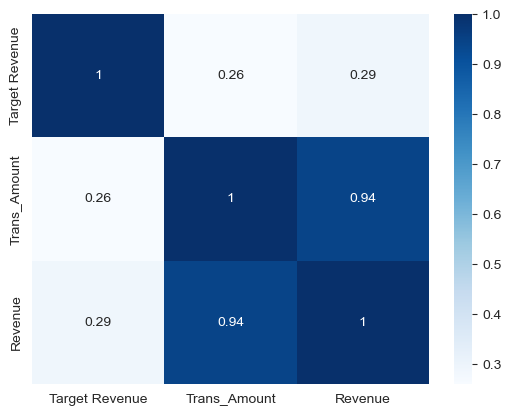

In [34]:
corr = df_main.corr(method="pearson")

sns.heatmap(corr,annot=True,cmap="Blues")

In [35]:
df_main.head()

,Date,Type,Card_Category,Target Revenue,Attrition_Flag,Trans_Amount,Revenue
0,"Q4,2019",Shop,Blue,11.320200,Existing Customer,34.424,1.72120
1,"Q3,2019",Eat,Gold,6.460272,Existing Customer,643.104,19.29312
2,"Q3,2019",Fuel,Blue,8.190468,Existing Customer,356.384,10.69152
3,"Q1,2019",Shop,Blue,2.757888,Existing Customer,32.832,0.98496
4,"Q4,2019",Eat,Blue,5.175828,Existing Customer,754.710,15.09420


In [36]:
df_main['Date'].nunique()

8

### Feature Eng

In [37]:
# Assuming df_main is your DataFrame
df_main['Revenue_Difference'] = df_main['Target Revenue'] - df_main['Revenue']

In [38]:
df_main['Date'].unique()

array(['Q4,2019', 'Q3,2019', 'Q1,2019', 'Q2,2019', 'Q3,2018', 'Q2,2018',
       'Q1,2018', 'Q4,2018'], dtype=object)

In [39]:
# Assuming df_main is your DataFrame
df_main['Quarter'] = df_main['Date'].str.extract('Q(\d)').astype(int)
df_main['Year'] = df_main['Date'].str.extract('(\d{4})').astype(int)

# Drop the original 'Date' column
df_main = df_main.drop(columns=['Date'])

In [40]:
df_main.head()

,Type,Card_Category,Target Revenue,Attrition_Flag,Trans_Amount,Revenue,Revenue_Difference,Quarter,Year
0,Shop,Blue,11.320200,Existing Customer,34.424,1.72120,9.599000,4,2019
1,Eat,Gold,6.460272,Existing Customer,643.104,19.29312,-12.832848,3,2019
2,Fuel,Blue,8.190468,Existing Customer,356.384,10.69152,-2.501052,3,2019
3,Shop,Blue,2.757888,Existing Customer,32.832,0.98496,1.772928,1,2019
4,Eat,Blue,5.175828,Existing Customer,754.710,15.09420,-9.918372,4,2019


In [41]:
df_main['Attrition_Flag'].unique()

array(['Existing Customer', 'Attrited Customer'], dtype=object)

In [42]:
# Assuming df_main is your DataFrame
df_main['Attrition_Flag_Encoded'] = df_main['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})

# Drop the original 'Attrition_Flag' column if needed
df_main = df_main.drop(columns=['Attrition_Flag'])

In [43]:
df_main['Card_Category'].unique()

array(['Blue', 'Gold', 'Silver', 'Platinum'], dtype=object)

In [44]:
# Assuming df_main is your DataFrame
df_main['Card_Category_Encoded'] = df_main['Card_Category'].map({'Blue': 0, 'Gold': 1,'Silver' : 2, 'Platinum' : 3})
# Drop the original 'Card_Category' column if needed
df_main = df_main.drop(columns=['Card_Category'])

In [45]:
df_main['Type'].unique()

array(['Shop', 'Eat', 'Fuel', 'Cash'], dtype=object)

In [46]:
# Assuming df_main is your DataFrame
df_main['Type_Encoded'] = df_main['Type'].map({'Shop': 0, 'Eat': 1, 'Fuel' : 2, 'Cash' : 3})
# Drop the original 'Type' column if needed
df_main = df_main.drop(columns=['Type'])

In [47]:
df_main.head()

,Target Revenue,Trans_Amount,Revenue,Revenue_Difference,Quarter,Year,Attrition_Flag_Encoded,Card_Category_Encoded,Type_Encoded
0,11.320200,34.424,1.72120,9.599000,4,2019,0,0,0
1,6.460272,643.104,19.29312,-12.832848,3,2019,0,1,1
2,8.190468,356.384,10.69152,-2.501052,3,2019,0,0,2
3,2.757888,32.832,0.98496,1.772928,1,2019,0,0,0
4,5.175828,754.710,15.09420,-9.918372,4,2019,0,0,1


## Modelling

In [48]:
## Independent and Dependent Features
y=df_main[['Revenue']]

In [49]:
X=df_main.drop(['Revenue'],axis=1)

In [50]:
df_main['Attrition_Flag_Encoded'].value_counts()

0    4734
1     266
Name: Attrition_Flag_Encoded, dtype: int64

<Axes: xlabel='Attrition_Flag_Encoded', ylabel='count'>

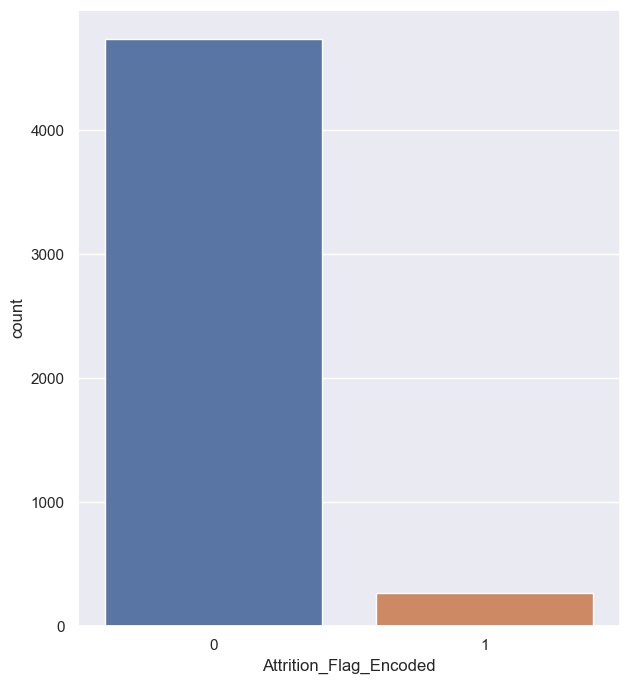

In [51]:
sns.set(rc={'figure.figsize':(7,8)})
sns.set_theme(style="darkgrid")
sns.countplot(x="Attrition_Flag_Encoded", data=df_main)

#### Split, Scale, Run Model

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2,random_state=43)

In [54]:
X_train.shape

(4000, 8)

In [55]:
X_test.shape

(1000, 8)

In [56]:
y_train.shape

(4000, 1)

In [57]:
y_test.shape

(1000, 1)

In [58]:
from sklearn.preprocessing import StandardScaler

In [59]:
scaler=StandardScaler()

In [60]:
X_train=scaler.fit_transform(X_train)

In [61]:
X_test=scaler.transform(X_test)

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming df_main is your DataFrame
# Define your features (X) and target variable (y)
X = df_main.drop(columns=['Revenue'])
y = df_main['Revenue']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model (example using Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 3.356912394415138e-27


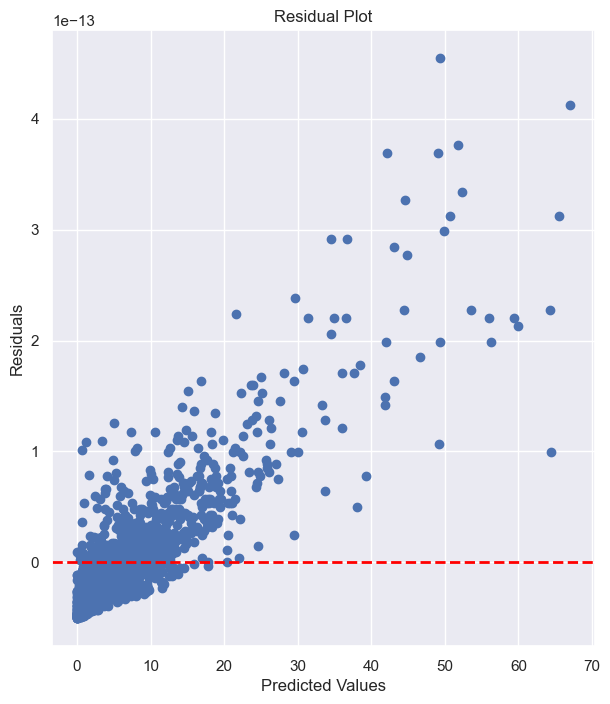

<Figure size 700x800 with 0 Axes>

In [63]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred

# Create a residual plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

plt.savefig(r'C:\\Users\\smrc\\OneDrive\\Desktop\\Credit Card Revenue Prediction\\images and plots\\residual plot.png')


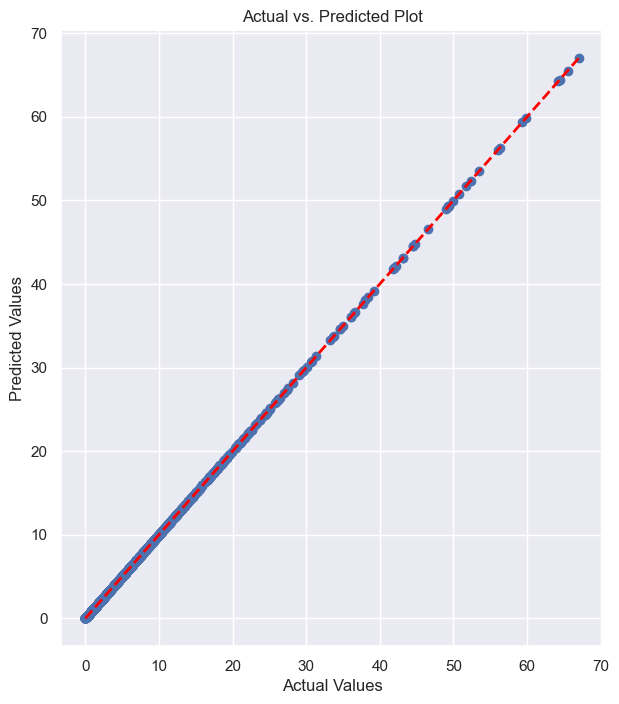

In [64]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Plot')
plt.show()



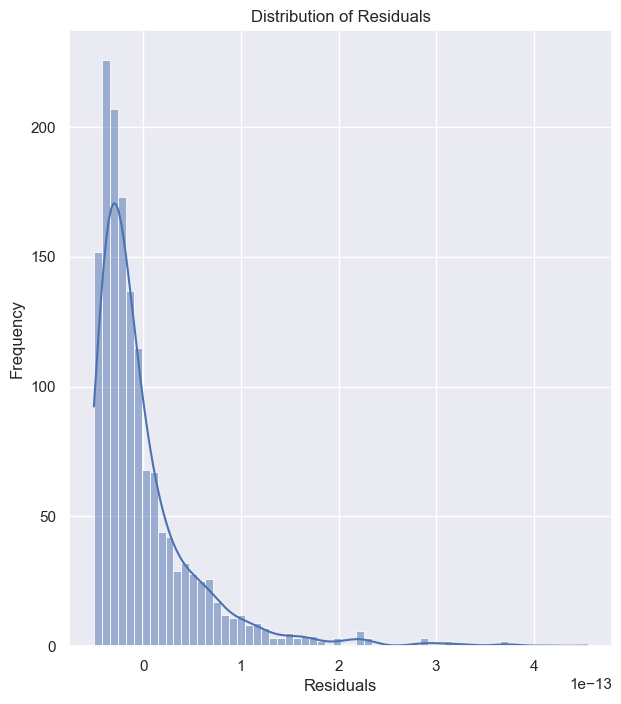

<Figure size 700x800 with 0 Axes>

In [65]:
import seaborn as sns

sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

plt.savefig(r'C:\\Users\\smrc\\OneDrive\\Desktop\\Credit Card Revenue Prediction\\images and plots\\distribution_of_residuals.png')


In [66]:
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')
print(f'Explained Variance: {explained_var}')

Mean Absolute Error: 3.815804575164765e-14
R-squared: 1.0
Explained Variance: 1.0


## Save Model

In [67]:
import os
from sklearn.linear_model import LinearRegression
import joblib

# Specify the directory to save the model
directory_path = r'C:\\Users\\smrc\\OneDrive\\Desktop\\Credit Card Revenue Prediction\\models'

# Save the model to the specified directory
model_path = os.path.join(directory_path, 'linear_regression_model.joblib')
joblib.dump(model, model_path)

print(f'Model saved to: {model_path}')


Model saved to: C:\\Users\\smrc\\OneDrive\\Desktop\\Credit Card Revenue Prediction\\models\linear_regression_model.joblib
